# Base case




In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import random
import scipy
import sklearn
from scipy import optimize
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
import sys
import time
import datetime as dt
import seaborn as sns

In [2]:
# initialize parameters of the DLC sequence x, y
case = 3
if case == 0:
    x = [[0,0,0]]
    y = [[0,0,0,0,0,0]]
    prefix = "basecase" 
elif case == 1:
    x = [[1,1,1]]
    y = [[1,1,1,1,1,1]]
    prefix = "offset1"
elif case == 2:
    x = [[2,2,2]]
    y = [[2,2,2,2,2,2]]
    prefix = "offset2"
elif case == 3:
    x = [[3,3,3]]
    y = [[3,3,3,3,3,3]]
    prefix = "offset3"


a = 8.7*0.01  #$/kWh  off_peak_price
b = 12.2*0.01  #$/kWh  mid_peak_price
c = 18.2*0.01  #$/kWh  on_peak_price
winter_prices = {0:a ,1:a ,2:a ,3:a ,4:a ,5:a ,6:a ,7:c ,8:c ,9:c ,10:c ,11:b ,12:b ,13:b ,14:b ,15:b ,16:b ,17:c ,18:c ,19:a ,20:a ,21:a ,22:a ,23:a }
summer_prices = {0:a ,1:a ,2:a ,3:a ,4:a ,5:a ,6:a ,7:b ,8:b ,9:b ,10:b ,11:c ,12:c ,13:c ,14:c ,15:c ,16:c ,17:b ,18:b ,19:a ,20:a ,21:a ,22:a ,23:a }
J_2_kWh = 1/3600000

discomfort_totalizer = 0
energy_totalizer = 0
cost_x = 0 # winter daily cost
cost_y = 0 # summer daily cost

cost_winter = []
cost_summer = []

tSetHtg_hndl=0; tSetClg_hndl=0; elect_hndl=0; tIn_office_hndl=0; tIn_lobby_hndl=0; handleDone=False
        
def my_callback_function(state):
    global discomfort_totalizer, energy_totalizer, x, y, cost_x, cost_y, exploration_x_count, exploration_y_count
    global tSetHtg_hndl, tSetClg_hndl, elect_hndl, tIn_office_hndl, tIn_lobby_hndl, handleDone
    if api.exchange.warmup_flag(state):
        return
    envNum = api.exchange.current_environment_num(state)
    if envNum == 3: # if sizing done
        if not handleDone:
            if api.exchange.api_data_fully_ready(state):
                tSetHtg_hndl = api.exchange.get_actuator_handle(state, "Schedule:Constant", "Schedule Value", "tSetHtg")
                tSetClg_hndl = api.exchange.get_actuator_handle(state, "Schedule:Constant", "Schedule Value", "tSetClg")
                elect_hndl = api.exchange.get_meter_handle(state,"Electricity:Facility")
                tIn_office_hndl = api.exchange.get_variable_handle(state,"Zone Mean Air Temperature","Office")
                tIn_lobby_hndl = api.exchange.get_variable_handle(state,"Zone Mean Air Temperature","Lobby")
                if -1 in [tSetHtg_hndl, tSetClg_hndl, elect_hndl, tIn_office_hndl, tIn_lobby_hndl]:
                    sys.exit(1)
                handleDone = True
            else:
                return

        # exchange information with EnergyPlus
        meter_reading = api.exchange.get_meter_value(state,elect_hndl)
         
        tIn_office = api.exchange.get_variable_value(state,tIn_office_hndl)
        tIn_lobby = api.exchange.get_variable_value(state,tIn_lobby_hndl)
        month = api.exchange.month(state) 
        time_of_day = api.exchange.hour(state)
        minutes = api.exchange.minutes(state)
        day_of_week = api.exchange.day_of_week(state) # 1 = Sunday
        day_of_month = api.exchange.day_of_month(state)
        
        # calculate price based on time of day & season
        if ((month > 10) or (month < 5)) and (day_of_week > 1 and day_of_week < 8):  # winter, weekday
            energy_dollars = meter_reading * J_2_kWh * winter_prices[time_of_day]
        elif ((month > 4) and (month < 11)) and (day_of_week > 1 and day_of_week < 8): # summer, weekday
            energy_dollars = meter_reading * J_2_kWh * summer_prices[time_of_day]
        else:  # weekend
            energy_dollars = meter_reading * J_2_kWh * a
                
        
        api.exchange.set_actuator_value(state, tSetHtg_hndl, 18)
        api.exchange.set_actuator_value(state, tSetClg_hndl, 27)

        if (day_of_week > 1 and day_of_week < 8):
            if (time_of_day >= 7 and time_of_day < 17):
                api.exchange.set_actuator_value(state, tSetHtg_hndl, 21)
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24)

        # actuate setpoints based on winter DLC parameter array x
        if ((month > 10) or (month < 5)) and (day_of_week > 1 and day_of_week < 8):
            if (time_of_day >= 7 - x[0][0]) and (time_of_day < 7): # preheat winter off-peak
                api.exchange.set_actuator_value(state, tSetHtg_hndl, 21 + x[0][1])
            if (time_of_day >= 7) and (time_of_day < 11): # setback winter on-peak
                api.exchange.set_actuator_value(state, tSetHtg_hndl, 21 - x[0][2])

        # actuate setpoints based on summer parameter array y   
        if ((month > 4) and (month < 11)) and (day_of_week > 1 and day_of_week < 8):
            if (time_of_day >= 7 - y[0][0]) and (time_of_day < 7): # precool summer off-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24 - y[0][1])
            if (time_of_day >= 7) and (time_of_day < 7 + y[0][2]): # setup summer mid-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24 + y[0][3])
            if (time_of_day >= 7 + y[0][2]) and (time_of_day < 11): # precool summer mid-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24 - y[0][4])
            if (time_of_day >= 11) and (time_of_day < 17): # setup summer on-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24 + y[0][5])

        # at the end of the day update cost_x to update cost model for winter
        if ((month > 10) or (month < 5)) and (day_of_week > 1 and day_of_week < 8):
            if (time_of_day < 23):
                cost_x = 0
                energy_totalizer = energy_totalizer + energy_dollars
                if (time_of_day >= 8 and time_of_day < 17):
                    if ((tIn_office < 20) or (tIn_office > 25) or (tIn_lobby < 20) or (tIn_lobby > 25)):
                        discomfort_totalizer = discomfort_totalizer + 1
            elif (cost_x == 0):
                cost_x = (energy_totalizer) * (1 + (discomfort_totalizer > 4)) + 0.0000001
                discomfort_totalizer = 0
                energy_totalizer = 0
                cost_winter.append(cost_x)           

        # at the end of the day update cost_y to update cost model for summer
        if ((month > 4) and (month < 11)) and (day_of_week > 1 and day_of_week < 8):
            if (time_of_day < 23):
                cost_y = 0
                energy_totalizer = energy_totalizer + energy_dollars
                if (time_of_day >= 8 and time_of_day < 17):
                    if ((tIn_office < 20) or (tIn_office > 25) or (tIn_lobby < 20) or (tIn_lobby > 25)):
                        discomfort_totalizer = discomfort_totalizer + 1
            elif (cost_y == 0):
                cost_y = (energy_totalizer) * (1 + (discomfort_totalizer > 4)) + 0.0000001
                discomfort_totalizer = 0
                energy_totalizer = 0
                cost_summer.append(cost_y)
                

In [15]:
import sys
sys.path.insert(0, 'C:\EnergyPlusV23-1-0')  # add E-Plus directory to path to be able to import API
from pyenergyplus.api import EnergyPlusAPI #import EnergyPlus library
api = EnergyPlusAPI()
state = api.state_manager.new_state() 
api.runtime.clear_callbacks()
api.functional.clear_callbacks()
# energyplus model calling point, callback function
api.runtime.callback_begin_system_timestep_before_predictor(state,my_callback_function)
# run EPlus
epwFile = 'POWER_Point_Hourly_20190101_20191231_043d6690N_079d6196W_LST.epw'
idfFile = '3-baseline_unitary_elec_v2.idf'

# -x short form to run expandobjects for HVACtemplates. see EnergyPlusEssentials.pdf p16
cmd_args = ['-w',epwFile, '-d', 'out_{}'.format(prefix),'-x',idfFile]
api.runtime.run_energyplus(state,cmd_args)

df = pd.DataFrame([cost_winter, cost_summer]).transpose()
df.columns = ["cost_winter","cost_summer"]
df.to_csv('{}_data.csv'.format(prefix), index=False)

### Plot Temperature profile

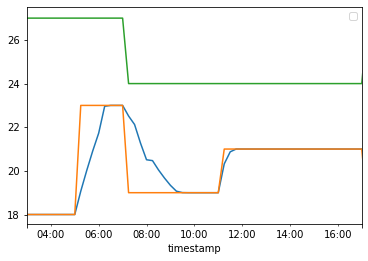

In [38]:
time_range = pd.date_range(start='2019-01-01 00:15:00', end='2020-1-1 00:00:00', freq='15T')
df= pd.read_csv('out_offset2/eplusout.csv')#[:-1]  # remove last time step 31/12 24:00 
df["timestamp"] = time_range
df.set_index('timestamp', inplace=True)
df_filter = df.filter(regex="OFFICE:Zone Thermostat|OFFICE:Zone Mean Air Temperature")
df_filter.plot()
month = 1; day = 5
plt.xlim([dt.datetime(2019, month, day,3,0,0), dt.datetime(2019, month, day,17,0,0)])
plt.legend([])

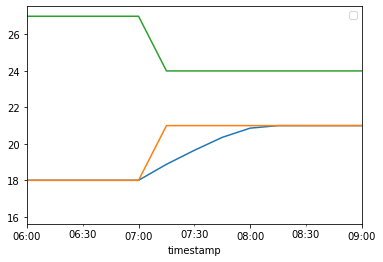

In [54]:
time_range = pd.date_range(start='2019-01-01 00:15:00', end='2020-1-1 00:00:00', freq='15T')
df= pd.read_csv('out_basecase/eplusout.csv')#[:-1]  # remove last time step 31/12 24:00 
df["timestamp"] = time_range
df.set_index('timestamp', inplace=True)
df_filter = df.filter(regex="OFFICE:Zone Thermostat|OFFICE:Zone Mean Air Temperature")
df_filter.plot()
month = 1; day = 2
plt.xlim([dt.datetime(2019, month, day,6,0,0), dt.datetime(2019, month, day,9,0,0)])
plt.legend([])

### Plot cost

Text(0, 0.5, 'Total cost')

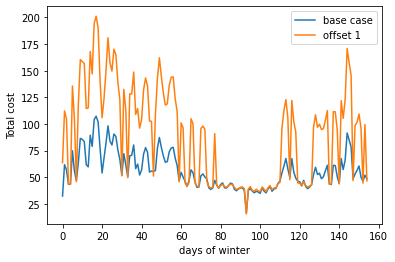

In [61]:
df_basecase = pd.read_csv('basecase_data.csv')
df_offset1 = pd.read_csv('offset2_data.csv')

plt.plot(df_basecase["cost_winter"], label="base case")
plt.plot(df_offset1["cost_winter"], label="offset 1")
plt.legend()
plt.xlabel("days of winter")
plt.ylabel("Total cost")
# plt.xlim([0, 40])

Text(0, 0.5, 'Total cost')

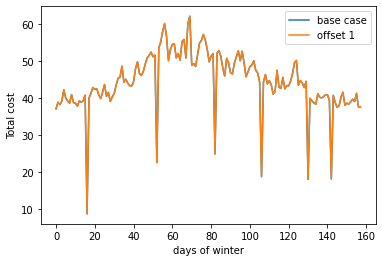

In [28]:
df_basecase = pd.read_csv('basecase_data.csv')
df_offset1 = pd.read_csv('offset3_data.csv')

plt.plot(df_basecase["cost_summer"], label="base case")
plt.plot(df_offset1["cost_summer"], label="offset 1")
plt.legend()
plt.xlabel("days of winter")
plt.ylabel("Total cost")
# plt.xlim([0, 40])

### Calculate energy savings

In [15]:
def get_price_winter(hour):
        return winter_prices.get(hour)
def get_price_summer(hour):
        return summer_prices.get(hour)
def calc_energy_cost(df, time_range):
    df["timestamp"] = time_range
    # add winter prices 
    df['prices'] = df['timestamp'].dt.hour.apply(get_price_winter)
    # add summer prices
    df.loc[(df['timestamp'].dt.month > 4) & (df['timestamp'].dt.month < 11), 'prices'] = df['timestamp'].dt.hour.apply(get_price_summer)
    df["HVAC"] = df["Heating:Electricity [J](TimeStep)"] + df["Cooling:Electricity [J](TimeStep)"]  #"Electricity:Facility [J](TimeStep)"
    df["energy_cost"] = df["HVAC"] * J_2_kWh * df["prices"]
    return df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   basecase  12 non-null     float64
 1   offset1   12 non-null     float64
 2   offset2   12 non-null     float64
 3   offset3   12 non-null     float64
 4   months    12 non-null     object 
dtypes: float64(4), object(1)
memory usage: 608.0+ bytes


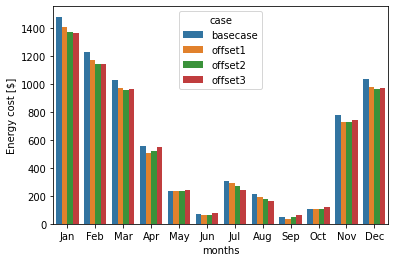

In [16]:
en_lst = []
filenames = ["basecase","offset1","offset2","offset3"]
time_range = pd.date_range(start='2019-01-01 00:15:00', end='2020-1-1 00:00:00', freq='15T')
for name in filenames:
    df= pd.read_csv('out_{}/eplusout.csv'.format(name))
    df = calc_energy_cost(df, time_range)
    df.set_index('timestamp', inplace=True)
    monthly_prices = df['energy_cost'].resample('M').sum()
    en_lst.append(monthly_prices.values)
    
df_all_energy = pd.DataFrame(en_lst).transpose()[:-1]
df_all_energy.columns = ["basecase", "offset1", "offset2", "offset3"]

df_all_energy["months"] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_all_energy.info()

df_melt = pd.melt(df_all_energy, id_vars="months",var_name="case")
sns.barplot(data=df_melt, x="months", y="value", hue="case").set(ylabel="Energy cost [$]")
plt.show()

In [17]:
annual = df_all_energy.sum().values[0:4]
perc_savings = (annual[1:4] - annual[0])*100/annual[0]
print(perc_savings)

[-6.044904351911201 -7.411113354003735 -6.5752616690420576]


### Calculate discomfort

In [58]:
def calc_discomfort(df, time_range):
    df["timestamp"] = time_range
    df[["occupied", "overall_discomfort"]] = 0
    # 0: Monday 6:Sunday
    df.loc[(df["timestamp"].dt.dayofweek < 6) & (df["timestamp"].dt.hour >=8) & (df["timestamp"].dt.hour <17),"occupied"] = 1
    office_dev_cond = (df["OFFICE:Zone Mean Air Temperature [C](TimeStep)"] < 20) | (df["OFFICE:Zone Mean Air Temperature [C](TimeStep)"] > 25)
    lobby_dev_cond = (df["LOBBY:Zone Mean Air Temperature [C](TimeStep)"] < 20) | (df["LOBBY:Zone Mean Air Temperature [C](TimeStep)"] > 25)
    df.loc[(df["occupied"]==1) & (office_dev_cond | lobby_dev_cond) ,"overall_discomfort"] = 1
    return df
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   basecase  12 non-null     float64
 1   offset1   12 non-null     float64
 2   offset2   12 non-null     float64
 3   offset3   12 non-null     float64
 4   months    12 non-null     object 
dtypes: float64(4), object(1)
memory usage: 608.0+ bytes


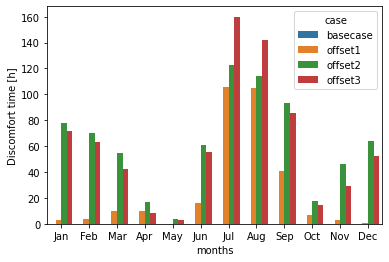

In [59]:
ts_2_h = 15/60
discomfort_lst = []
filenames = ["basecase","offset1","offset2","offset3"]
time_range = pd.date_range(start='2019-01-01 00:15:00', end='2020-1-1 00:00:00', freq='15T')
for name in filenames:
    df= pd.read_csv('out_{}/eplusout.csv'.format(name))
    df = calc_discomfort(df, time_range)
    df.set_index('timestamp', inplace=True)
    monthly_discomfort = df['overall_discomfort'].resample('M').sum()*ts_2_h
    discomfort_lst.append(monthly_discomfort.values)

df_all_discomfort = pd.DataFrame(discomfort_lst).transpose()[:-1]
df_all_discomfort.columns = ["basecase", "offset1", "offset2", "offset3"]

df_all_discomfort["months"] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_all_discomfort.info() 

df_melt = pd.melt(df_all_discomfort, id_vars="months",var_name="case")
sns.barplot(data=df_melt, x="months", y="value", hue="case").set(ylabel="Discomfort time [h]")
plt.show()

### Cold day and hot day plots